# Regression
## Machine Learning

### This notebook presents some tests on Regression, including Linear Regression, Ridge Regression, Neural Networks for Regression.
### The dataset used in this example is the California Housing Prices, which can be dowloaded from [Kaggle](https://www.kaggle.com/camnugent/california-housing-prices).

#### This notebook uses Python version 3.6 or newer.

Let's start by checking the Python version.

In [1]:
import sys

if int(sys.version[0]) < 3 or int(sys.version[2]) < 6:
    assert("Python version 3.6 or newer is required")

We continue by importing the necessary libraries and toolkits.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD


%matplotlib inline

## Data Exploration

Let's load the dataset into a Pandas Dataframe and take perform some data exploration.

In [3]:
df = pd.read_csv('./housing.csv', sep=',')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Let's check the column types, to make sure the dataset was properly loaded.

In [4]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Let's check the number records in this dataset.

In [5]:
df.shape[0]

20640

Now, let's check for NULL values.

In [6]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

We can see that 207 out of 20640 records contain NULL values for the number of bedrooms in the house. <br/>
This comprises about 1% of the data.

Let's take a better look on our data, from a statistical point of view

In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Let's see a histogram of the Media House Values.

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

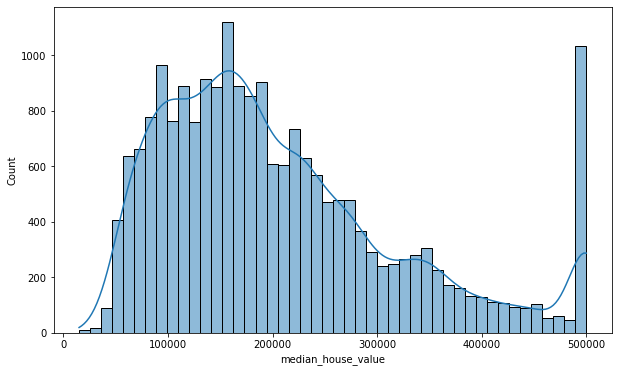

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(df, x='median_house_value', kde=True)

Let's see how the location affects the Median House Value.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

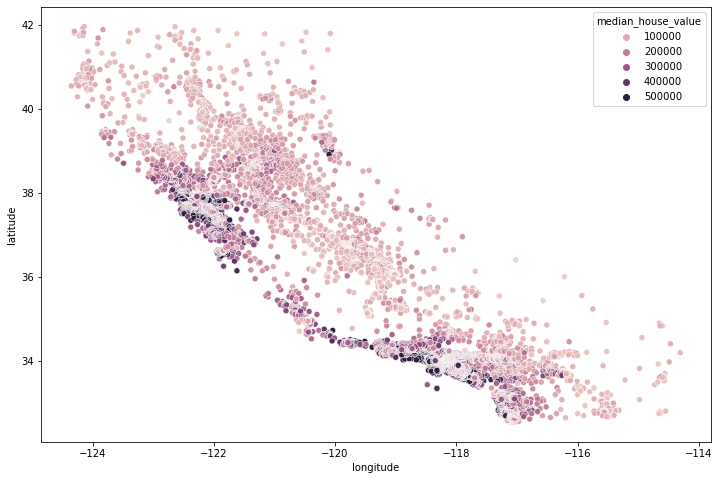

In [9]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude',y='latitude',data=df,hue='median_house_value')

Let's see the correlation between the data attributes.

<AxesSubplot:>

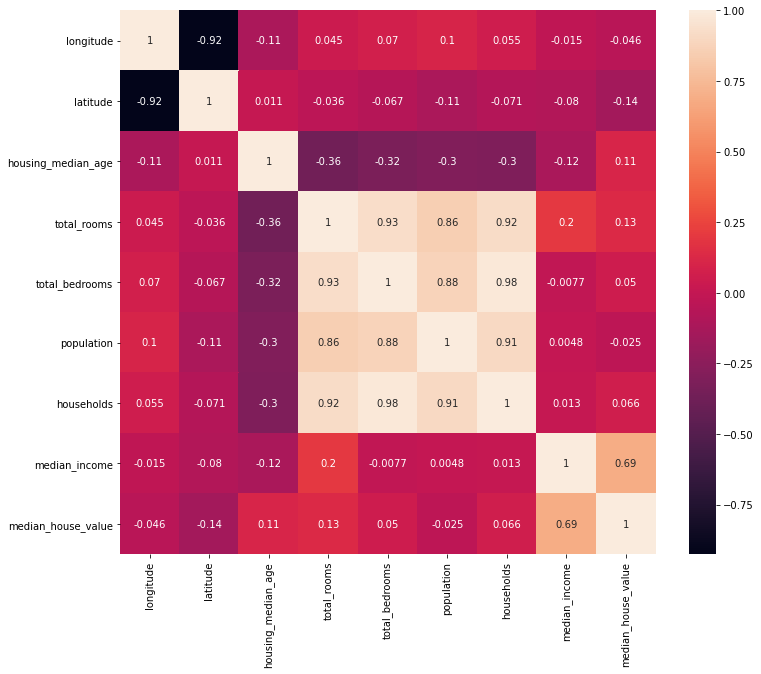

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

## Data Preprocessing

The first problem we have to solve is deciding what to do with the NULL values.<br/>
Should we drop the records with such values or should we replace them with some other value, like the mean value (or the highest/lowest/median etc.)?

In this example, we are going to drop these records, since they are too few to affect the outcome.

In [11]:
df.dropna(inplace=True)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Now, we should replace the textual "Ocean Proximity" feature, which is actually a categorical feature, with a numeric value, to make sure we only have numeric values for the regression.

In [12]:
dummy = pd.get_dummies(df['ocean_proximity'])
df = pd.concat([df, dummy], axis=1)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,0,0,0,1,0


What should we do with the geographic coordinates?<br/>
The simplest approach is converting geolocation data into zones, using some clustering technique.

In [13]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(df[['longitude','latitude']])

KMeans(n_clusters=10, random_state=0)

Let's integrate the lables into our dataframe.

In [14]:
df['area'] = kmeans.labels_.astype('uint8')
dummy = pd.get_dummies(df['area'])
df = pd.concat([df, dummy], axis=1)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,...,0,1,2,3,4,5,6,7,8,9
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,...,0,1,0,0,0,0,0,0,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,...,0,1,0,0,0,0,0,0,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,...,0,1,0,0,0,0,0,0,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,...,0,1,0,0,0,0,0,0,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,...,0,1,0,0,0,0,0,0,0,0


Let's check the column types, to make sure the dataset was properly modified.

In [15]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
<1H OCEAN               uint8
INLAND                  uint8
ISLAND                  uint8
NEAR BAY                uint8
NEAR OCEAN              uint8
area                    uint8
0                       uint8
1                       uint8
2                       uint8
3                       uint8
4                       uint8
5                       uint8
6                       uint8
7                       uint8
8                       uint8
9                       uint8
dtype: object

Now, we have finalized all the data preprocessing and we can proceed with the regression.

The next problem we need to solve is deciding on the features we are going to use to train the regressor.

We can safely discard the textual Ocean Proximity feature, since we have the numerical one.<br/>
We can also discard the Longitude and Latitude features, since we have engineered the labels.<br/>

Now, we should separate the the features from the target

In [16]:
targets = ['median_house_value']
y = df[targets]
X = df.drop(['longitude','latitude','median_house_value','ocean_proximity', 'area'], axis=1)

Since we are going to perform regression we need to standardize and/or normalize our data, to improve the regression's accuracy.<br/>

In our example, we are going to perform Ridge Regression, which is a form of Linear Regression, we should scale our data.

In [17]:
xscaler = MinMaxScaler()
num_features_X = X.dtypes[X.dtypes == 'float64'].index
X.loc[:,num_features_X] = xscaler.fit_transform(X[num_features_X].values)
X.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,...,0,1,2,3,4,5,6,7,8,9
0,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [18]:
yscaler = MinMaxScaler()
num_features_y = y.dtypes[y.dtypes == 'float64'].index
y.loc[:,num_features_y] = yscaler.fit_transform(y[num_features_y].values)
y.head()

/mnt/disk/bishop/miniconda3/envs/ml/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/mnt/disk/bishop/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,median_house_value
0,0.902266
1,0.708247
2,0.695051
3,0.672783
4,0.674638


## Training & Testing sets

Let's split the data into training and validation sets. We keep 80% of the data for training and 20% for validation.<br/>
These exact sets are going to be used for all 3 kinds of Gradient Descend for Ridge Regression.

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
print(f"Number of training points: {X_train.shape[0]}")
print(f"Number of validation points: {X_valid.shape[0]}")

Number of training points: 16346
Number of validation points: 4087


In [20]:
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()

## Regressor

Now we are going to proceed to the Ridge Regression through (mini-)batch Gradient Descend.

The Ridge Regression is performed using the following cost function:<br/>

$J(\textbf{w}) = COST_\mathbf{w}(\mathbf{X},\mathbf{y})+\alpha \sum_{i=1}^m w_i^2 \\
\hspace{1cm} = COST_\mathbf{w}(\mathbf{X},\mathbf{y})+\alpha (\mathbf{w}^\top \mathbf{w})$

In the cost function above, $COST_\mathbf{w}(\mathbf{X},\mathbf{y})$ can be any of the following 3 distinct cost functions:
* Residual sum of squares (**RSS**)
* Mean squared error (**MSE**)
* Root mean squared error (**RMSE**)

The gradient of the cost function above is the following:<br/>
$\nabla_\mathbf{w} J(\textbf{w}) = \nabla_\mathbf{w} COST_\mathbf{w}(\mathbf{X},\mathbf{y})+\alpha \nabla_\mathbf{w} (\mathbf{w}^\top \mathbf{w}) \\
\hspace{1.65cm} = \nabla_\mathbf{w} COST_\mathbf{w}(\mathbf{X},\mathbf{y}) + 2 \alpha \mathbf{w}$

Let's perform a recap on the mathematics behind these 3 cost functions.

* $RSS = \sum_{i=1}^m (h_\mathbf{w}(\mathbf{x}_i)-y_i)^2$
* $MSE = \frac{1}{m} \sum_{i=1}^m (h_\mathbf{w}(\mathbf{x}_i)-y_i)^2$
* $RMSE = \sqrt{\frac{1}{m} \sum_{i=1}^m (h_\mathbf{w}(\mathbf{x}_i)-y_i)^2}$

where $h_\mathbf{w}(\mathbf{x}_i)=\mathbf{w}^\top \mathbf{x}_i$

Now, let's see what the gradients of these 3 cost functions are.
* $\frac{\partial}{\partial w_j} RSS = 2 \sum_{i=1}^m (h_\mathbf{w}(\mathbf{x}_i)-y_i) x_{ij} \\
\implies \nabla_\mathbf{w} RSS = 2 \mathbf{X}^\top(\mathbf{Xw}-\mathbf{y})$

* $\frac{\partial}{\partial w_j} MSE = \frac{2}{m} \sum_{i=1}^m (h_\mathbf{w}(\mathbf{x}_i)-y_i) x_{ij} = \frac{1}{m} \frac{\partial}{\partial w_j} RSS \\
\implies \nabla_\mathbf{w} MSE = \frac{2}{m} \mathbf{X}^\top(\mathbf{Xw}-\mathbf{y})$

* $\frac{\partial}{\partial w_j} RMSE = \
\frac{1}{2} \frac{1}{\sqrt{\frac{1}{m} \sum_{i=1}^m (h_\mathbf{w}(\mathbf{x}_i)-y_i)^2}} \frac{2}{m} \sum_{i=1}^m (h_\mathbf{w}(\mathbf{x}_i)-y_i) x_{ij} \
= \frac{1}{2} \frac{1}{\sqrt{MSE}} \frac{\partial}{\partial w_j} MSE \\
\implies \nabla_\mathbf{w} RMSE = \frac{1}{2} \frac{1}{\sqrt{MSE}} \nabla_\mathbf{w} MSE$

Let's define a custom class which helps with performing (mini-)batch Gradient Descend for Ridge Regression.<br/>
This class is implemented so that we can keep a record of the cost for both for training and validation sets, for as many epochs as we have decided.<br/>

In [21]:
class BatchRidgeRegressor:
    def __init__(self, batch_size=None, alpha=0.0001, epochs=1000, learning_rate=0.01, cost='mse'):
        self.__batch_size=batch_size # 
        self.__alpha=alpha
        self.__epochs=epochs
        self.__learning_rate=learning_rate
        self.__weights=None
        
        if cost == 'rss':
            self.__cost = self.__rss
            self.__gradient = self.__rss_grad
        elif cost == 'mse':
            self.__cost = self.__mse
            self.__gradient = self.__mse_grad
        elif cost == 'rmse':
            self.__cost = self.__rmse
            self.__gradient = self.__rmse_grad
    
    def fit(self, X_train, X_valid, y_train, y_valid):
        # Add a column of ones to X for the bias term
        X_train = np.c_[ X_train, np.ones(X_train.shape[0]) ]
        X_valid = np.c_[ X_valid, np.ones(X_valid.shape[0]) ]
        
        # Make sure the shape of y is correct by
        # reshaping it into a (n,1) vector, if needed.
        if len(y_train.shape) == 1:
            y_train = y_train.reshape(-1, 1)
        if len(y_valid.shape) == 1:
            y_valid = y_valid.reshape(-1, 1)
        
        # Create inital weights w0, w1, ..., wn with zero values
        w = np.zeros((X_train.shape[1],1))
        
        # Initialize cost lists (both trainings and validation),
        # useful for plotting changes
        train_costs = []
        valid_costs = []
        
        if not self.__batch_size:
            # Full batch
            for epoch in range(self.__epochs):
                # Update weights
                w -= self.__learning_rate * self.__gradient(X_train, y_train, w)
                
                # Useful for plotting loss progress
                train_cost = round(self.__cost(X_train, y_train, w), 5)
                valid_cost = round(self.__cost(X_valid, y_valid, w), 5)
                train_costs.append(train_cost)
                valid_costs.append(valid_cost)
                
        else:
            # Specific batch size
            for epoch in range(self.__epochs):
                # Shuffle training set
                X_train, y_train = shuffle(X_train, y_train)
                
                # Randomly choose batch indexes
                sample_ids = np.random.randint(0, X_train.shape[0]-self.__batch_size+1, 
                                               int(X_train.shape[0]/self.__batch_size))
                # Iterate over batches
                for i in sample_ids:
                    X = X_train[i:i+self.__batch_size]
                    y = y_train[i:i+self.__batch_size]
                    
                    # Update weights
                    w -= self.__learning_rate * self.__gradient(X, y, w)
                
                # Useful for plotting loss progress
                train_cost = round(self.__cost(X_train, y_train, w), 5)
                valid_cost = round(self.__cost(X_valid, y_valid, w), 5)
                train_costs.append(train_cost)
                valid_costs.append(valid_cost)
            
            # Store lastly updated parameter vector
            self.__weights = w
        
        return train_costs, valid_costs
    
    # Function to compute ridge RSS
    def __rss(self, X, y, w):
        #Initialization
        h = X @ w
        
        # Gradient Descend for Ridge Regression loss/cost computation
        J = ((h - y).T @ (h - y)) + self.__alpha * (w.T @ w)
        
        return J[0][0]
    
    # Function to compute ridge MSE
    def __mse(self, X, y, w):
        #Initialization
        m = X.shape[0]
        h = X @ w
        
        # Gradient Descend for Ridge Regression loss/cost computation
        J = (1.0 / m) * ((h - y).T @ (h - y)) + self.__alpha * (w.T @ w)
        
        return J[0][0]
    
    # Function to compute ridge RMSE
    def __rmse(self, X, y, w):
        #Initialization
        m = X.shape[0]
        h = X @ w
        
        # Gradient Descend for Ridge Regression loss/cost computation
        J = (1.0 / m) * (((h - y).T @ (h - y)) ** (1.0/2.0)) + self.__alpha * (w.T @ w)
        
        return J[0][0]
    
    # Function to compute gradient of RSS
    def __rss_grad(self, X, y, w):
        #Initialization
        h = X @ w
        
        # Gradient Descend for Ridge Regression gradient computation
        grad = 2.0 * (X.T @ (h - y)) + 2.0 * self.__alpha * w
        
        return grad
    
    # Function to compute gradient of MSE 
    def __mse_grad(self, X, y, w):
        #Initialization
        m = X.shape[0]
        h = X @ w
        
        # Gradient Descend for Ridge Regression gradient computation
        grad = (2.0/m) * (X.T @ (h - y)) + 2.0 * self.__alpha * w
        
        return grad
    
    # Function to compute gradient of RMSE 
    def __rmse_grad(self, X, y, w):
        #Initialization
        m = X.shape[0]
        h = X @ w
        
        # Gradient Descend for Ridge Regression gradient computation
        grad = (1.0/2.0) * (self.__mse(X, y, w) ** (-1.0/2.0)) * self.__mse_grad(X, y, w) + 2.0 * self.__alpha * w
        
        return grad
    
    # Function to compute predictions created for the current dataset
    # where y = w0 + w1*x1 +...+wn*xn 
    def predict(self, X):
        pred = X @ self.__weights[:-1] + self.__weights[-1]
        
        return pred

Now we have to choose the total number of batches. We can do that by using different batch sizes.<br>
The size of each batch is a fraction of the number of samples in our data. We can start from a small fraction and go up all the way to using all samples in a single batch.<br>
This means that with the final mini-batch we actually perform (full) Batch Gradient Descend.<br/>

Here, we use 10 distinct batch sizes, which produces batch sizes that start from 0.1 of the number of samples in our data, then 0.2, 0.3 and so on until 1.0 (full-batch).

In [22]:
num_batch_sizes = 10
batch_sizes = [int((i/num_batch_sizes)*X_train.shape[0]) for i in range(1,num_batch_sizes+1)]

## Linear Regression

These are the parameters that we are going to use to perform Gradient Descent for simple Linear Regression.

In [23]:
# Linear Regression parameters
alpha=0
epochs=3000
learning_rate=0.01
cost='rmse'

Let's perform the regression and plot the costs.<br/>

Performing Linear Regression with mini-batch Gradient Descent and batch size 1634
R-squared score: 0.64344


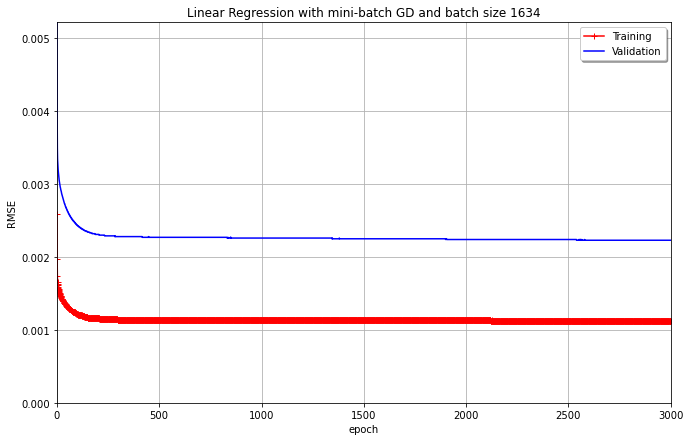

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Linear Regression with mini-batch Gradient Descent and batch size 3269
R-squared score: 0.63587


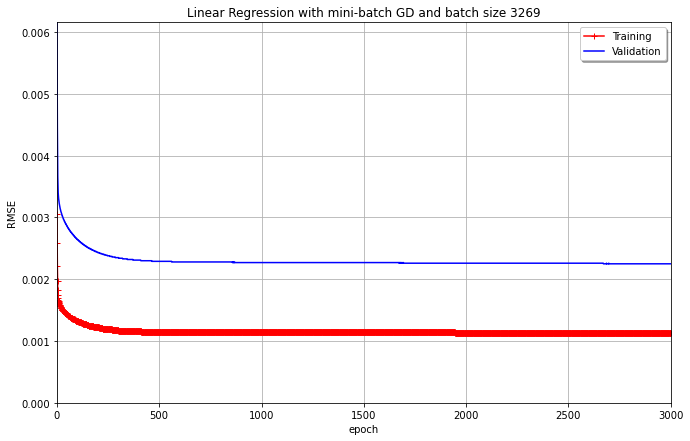

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Linear Regression with mini-batch Gradient Descent and batch size 4903
R-squared score: 0.63207


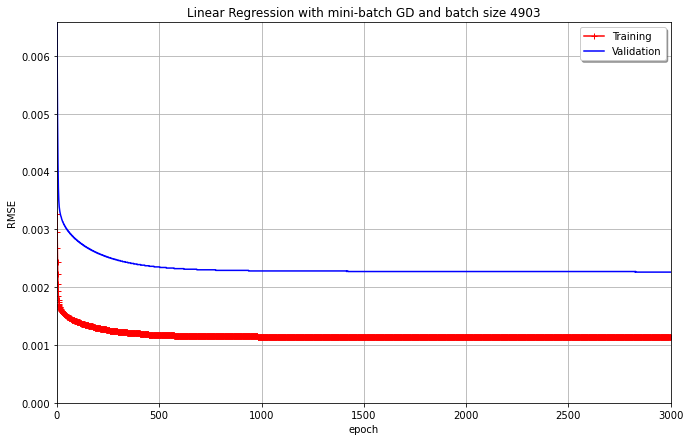

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Linear Regression with mini-batch Gradient Descent and batch size 6538
R-squared score: 0.62988


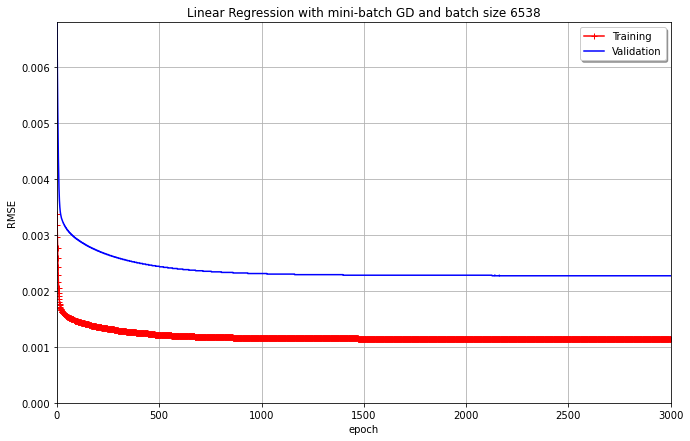

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Linear Regression with mini-batch Gradient Descent and batch size 8173
R-squared score: 0.62991


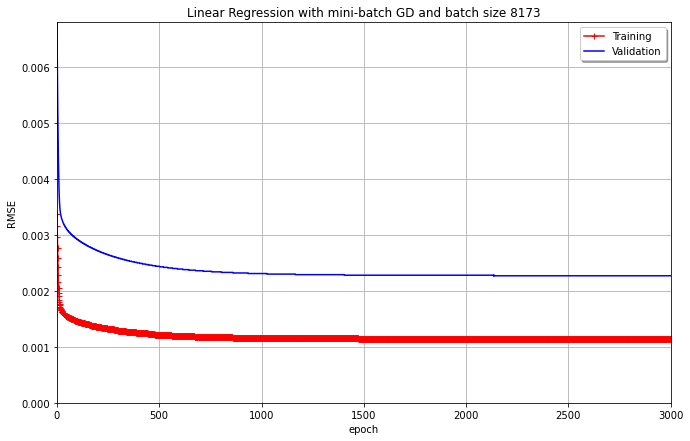

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Linear Regression with mini-batch Gradient Descent and batch size 9807
R-squared score: 0.62589


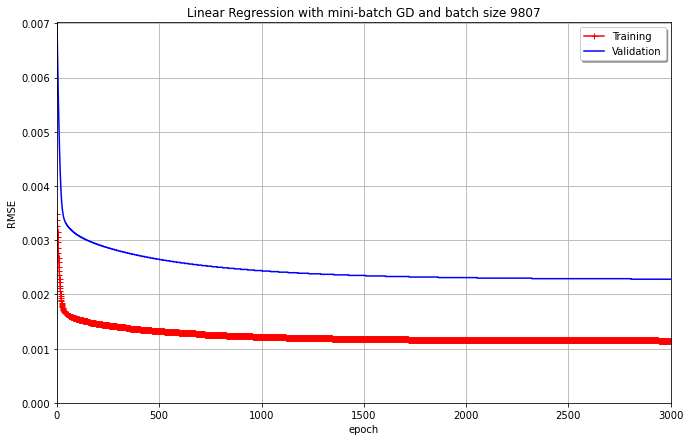

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Linear Regression with mini-batch Gradient Descent and batch size 11442
R-squared score: 0.62591


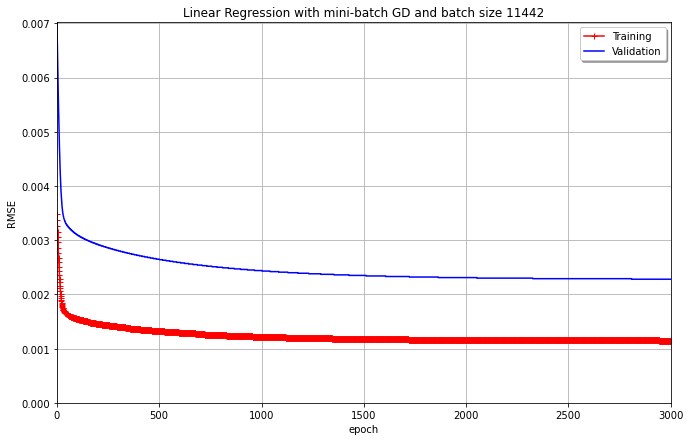

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Linear Regression with mini-batch Gradient Descent and batch size 13076
R-squared score: 0.62591


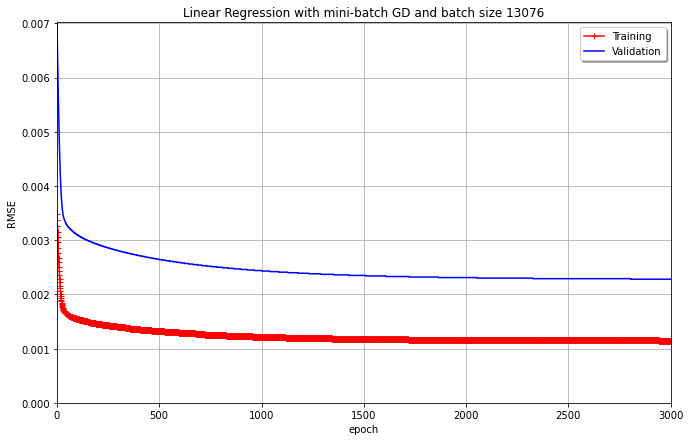

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Linear Regression with mini-batch Gradient Descent and batch size 14711
R-squared score: 0.62591


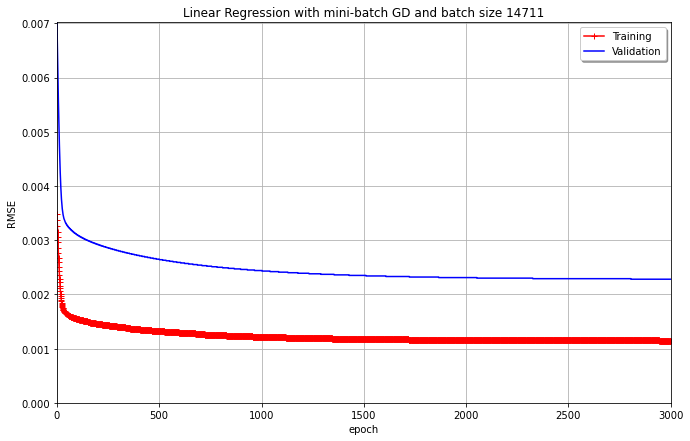

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Linear Regression with mini-batch Gradient Descent and batch size 16346 (full-batch)
R-squared score: 0.62591


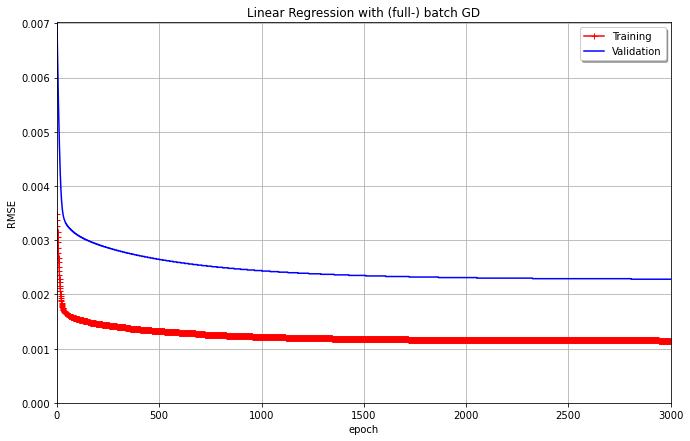

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [24]:
x_axis = list(range(epochs))

for batch_size in batch_sizes:
    if batch_size != X_train.shape[0]:
        print("Performing Linear Regression with mini-batch " + 
              f"Gradient Descent and batch size {batch_size}")
        title = f"Linear Regression with mini-batch GD and batch size {batch_size}"
    else:
        print("Performing Linear Regression with mini-batch " + 
              f"Gradient Descent and batch size {batch_size} (full-batch)")
        title = "Linear Regression with (full-) batch GD"

    regressor = BatchRidgeRegressor(batch_size=batch_size, alpha=alpha, epochs=epochs, \
                                    learning_rate=learning_rate, cost=cost)

    train_losses, valid_losses = regressor.fit(X_train, X_valid, y_train, y_valid)

    y_pred = regressor.predict(X_valid)
    r2 = r2_score(y_valid, y_pred)
    print(f"R-squared score: {round(r2, 5)}")

    fig = plt.figure(figsize=(11, 7))
    plt.plot(x_axis, train_losses, label="Training", color='r', marker='+')
    plt.plot(x_axis, valid_losses, label="Validation", color='b')
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.xlim(0,epochs)
    plt.ylim(0,max(max(train_losses),max(valid_losses)))
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

    print('-'*100)
    print('-'*100)
    print('')

So, from the curves above we can see that our model neither overfits nor underfits the data, since both curvers have the same behavior.<br/>
Moreover, the validation error is higher than the training error, as expected.<br/>
The $R^2$ score is about 0.6, which is neither good or bad. Maybe we could have better results if we used some non-linear regression method.

Let's see if we can do better with Ridge Regression (very unlikely though).

## Ridge Regression

These are the parameters that we are going to use to perform Gradient Descent for Ridge Regression.

In [25]:
# Ridge Regression parameters
alpha=0.00003
epochs=3000
learning_rate=0.01
cost='rmse'

Let's perform the regression and plot the costs.<br/>

Performing Ridge Regression with mini-batch Gradient Descent and batch size 1634
R-squared score: 0.64268


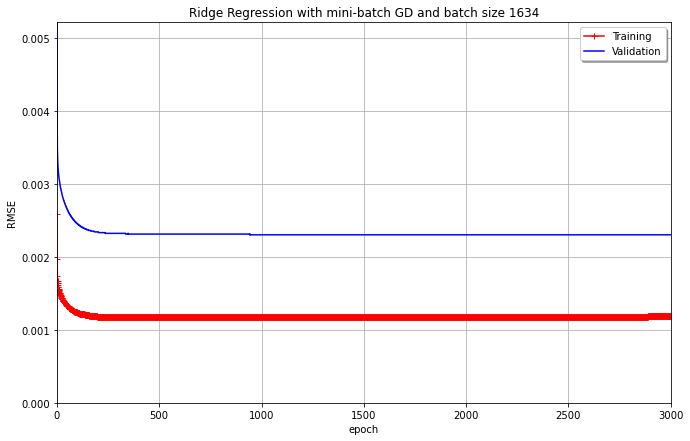

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Ridge Regression with mini-batch Gradient Descent and batch size 3269
R-squared score: 0.63571


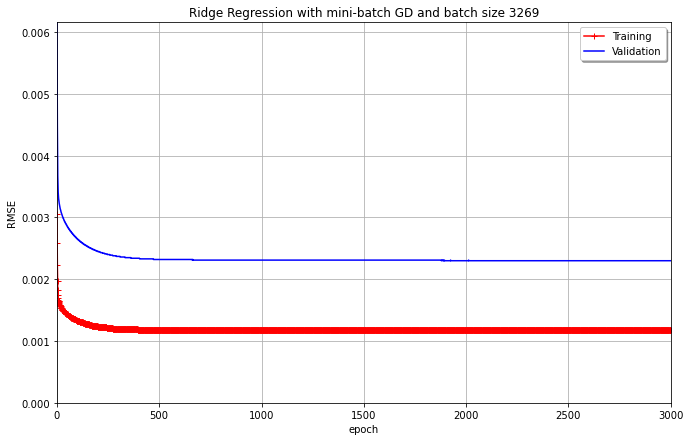

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Ridge Regression with mini-batch Gradient Descent and batch size 4903
R-squared score: 0.63195


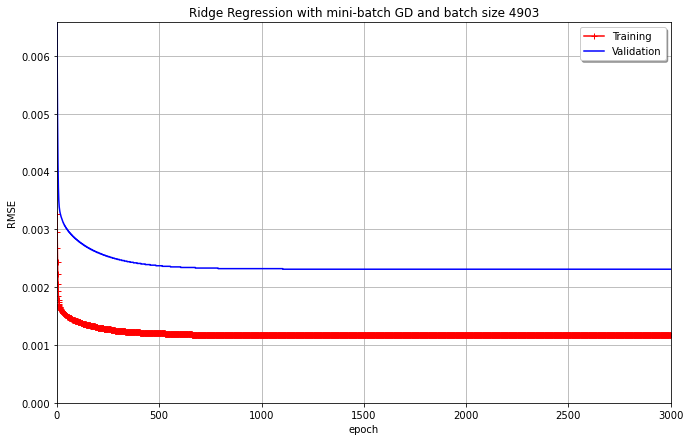

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Ridge Regression with mini-batch Gradient Descent and batch size 6538
R-squared score: 0.62984


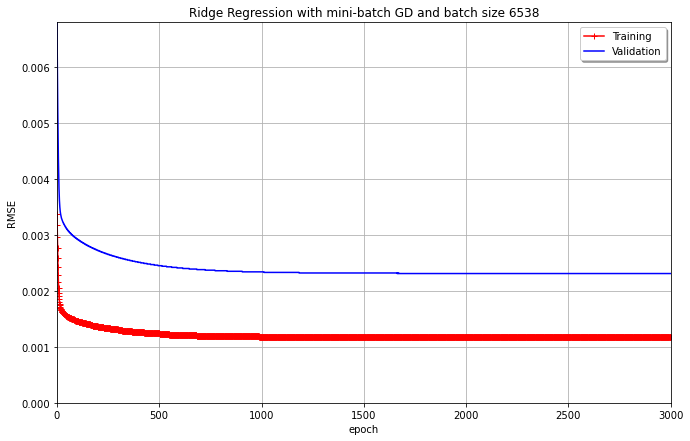

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Ridge Regression with mini-batch Gradient Descent and batch size 8173
R-squared score: 0.62984


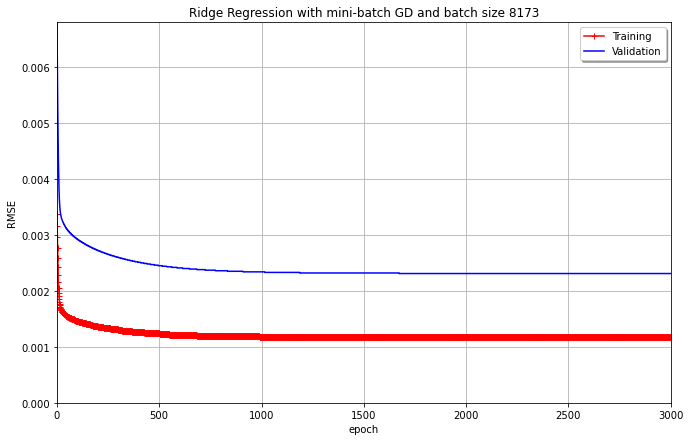

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Ridge Regression with mini-batch Gradient Descent and batch size 9807
R-squared score: 0.6258


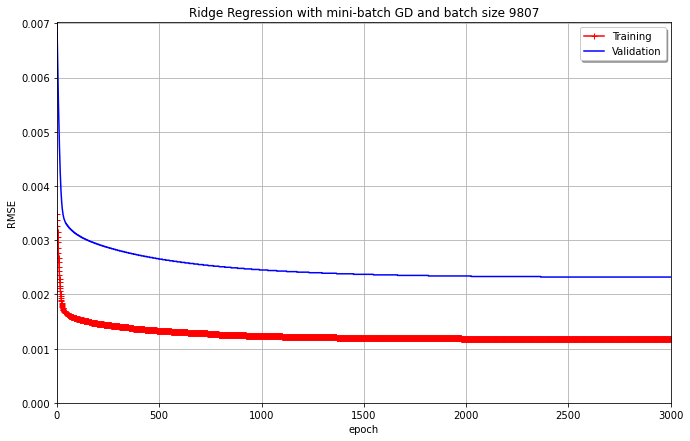

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Ridge Regression with mini-batch Gradient Descent and batch size 11442
R-squared score: 0.62578


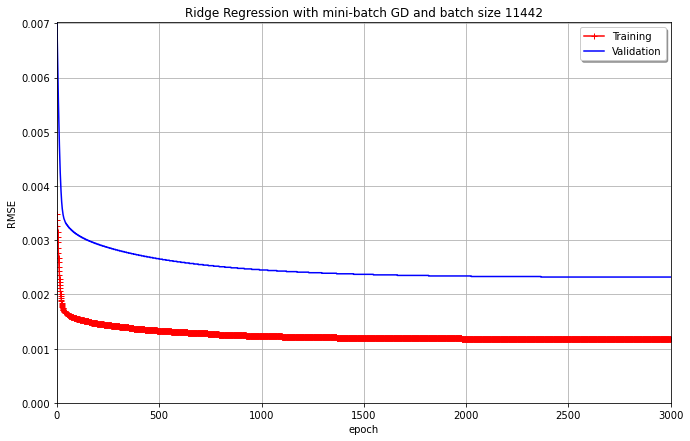

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Ridge Regression with mini-batch Gradient Descent and batch size 13076
R-squared score: 0.6258


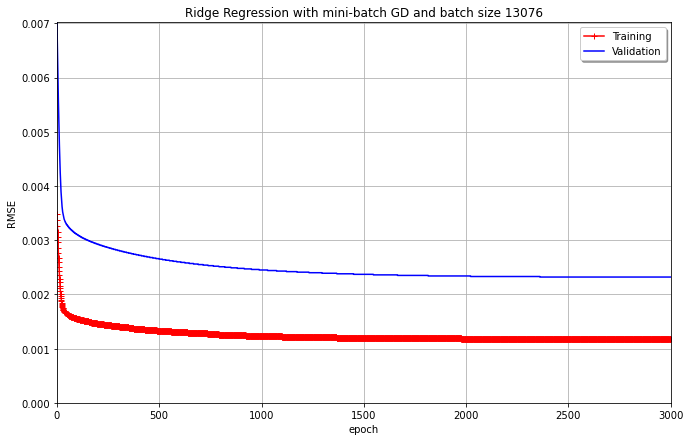

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Ridge Regression with mini-batch Gradient Descent and batch size 14711
R-squared score: 0.6258


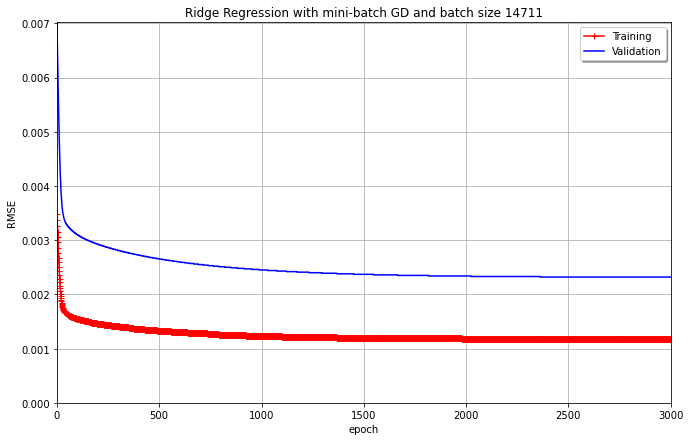

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Performing Ridge Regression with mini-batch Gradient Descent and batch size 16346 (full-batch)
R-squared score: 0.6258


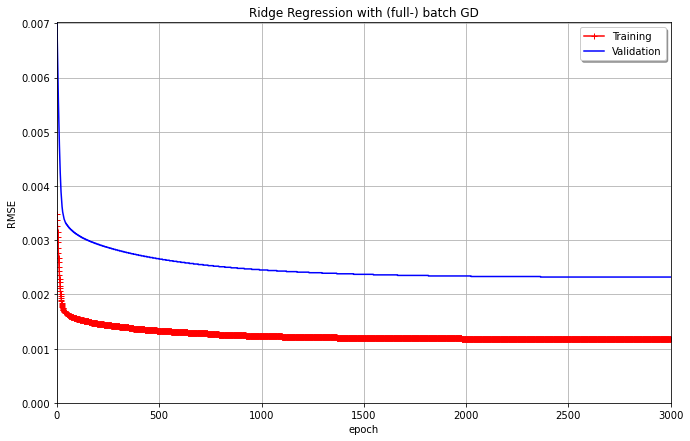

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [26]:
x_axis = list(range(epochs))

for batch_size in batch_sizes:
    if batch_size != X_train.shape[0]:
        print("Performing Ridge Regression with mini-batch " + 
              f"Gradient Descent and batch size {batch_size}")
        title = f"Ridge Regression with mini-batch GD and batch size {batch_size}"
    else:
        print("Performing Ridge Regression with mini-batch " + 
              f"Gradient Descent and batch size {batch_size} (full-batch)")
        title = "Ridge Regression with (full-) batch GD"

    regressor = BatchRidgeRegressor(batch_size=batch_size, alpha=alpha, epochs=epochs, \
                                    learning_rate=learning_rate, cost=cost)

    train_losses, valid_losses = regressor.fit(X_train, X_valid, y_train, y_valid)

    y_pred = regressor.predict(X_valid)
    r2 = r2_score(y_valid, y_pred)
    print(f"R-squared score: {round(r2, 5)}")
    
    fig = plt.figure(figsize=(11, 7))
    plt.plot(x_axis, train_losses, label="Training", color='r', marker='+')
    plt.plot(x_axis, valid_losses, label="Validation", color='b')
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.xlim(0,epochs)
    plt.ylim(0,max(max(train_losses),max(valid_losses)))
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

    print('-'*100)
    print('-'*100)
    print('')

So, from the curves above and the $R^2$ score we can see that our model does not perform much differently than the previous one, as was expected.<br/>
However, as the value of $\alpha$ increases, the RMSE cost will start increasing as well, instead of decreasing.

Generally, Linear Regression fits the training data better than Ridge Regression.

## Stochastic Gradient Descent

Now we are going to proceed to the stochastic Gradient Descend for Ridge Regression.

To perform Ridge Regression through stochastic Gradient Descend we are going to use the SGDRegressor class from scikit-learn.<br/>
From this class, we are going to perform the partial_fit method for training, so that we can keep a record of the RMSE for both for training and validation, for as many epochs as we have decided.

In [27]:
# Function to compute ridge RMSE
def cost(X, y, w, alpha):
    #Initialization
    m = X.shape[0]
    h = X @ w

    # Gradient Descend for Ridge Regression loss/cost computation
    J = (1.0 / m) * (((h - y).T @ (h - y)) ** (1.0/2.0)) + alpha * (w.T @ w)

    return J[0][0]

## Stochastic Gradient Descent for Linear Regression

These are the parameters that we are going to use to perform Stochastic Gradient Descent for simple Linear Regression.

In [28]:
# Stochastic Gradient Descent for Linear Regression parameters
loss='squared_loss'
alpha=0
epochs=500
eta0=0.01
learning_rate='invscaling'

Let's perform the regression and plot the costs.

R-squared score: 0.64283


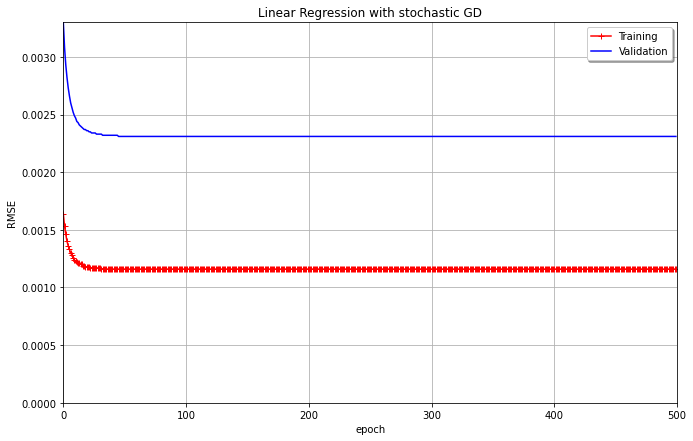

In [29]:
# Add a column of ones to X for the bias term
X_train_reshaped = np.c_[ X_train, np.ones(X_train.shape[0]) ]
X_valid_reshaped = np.c_[ X_valid, np.ones(X_valid.shape[0]) ]

# Make sure the shape of y is correct by
# reshaping it into a (n,1) vector, if needed.
if len(y_train.shape) != 1:
    y_train_reshaped = y_train.reshape(-1)

regressor = SGDRegressor(loss=loss, alpha=alpha, eta0=eta0, \
                         learning_rate=learning_rate, warm_start=True, \
                         random_state=0)

# Initialize cost lists (both trainings and validation),
# useful for plotting changes
train_costs = []
valid_costs = []

# In every epoch, use partial fit to stochastic regression
# over the whole training set
for i in range(epochs):
    regressor.partial_fit(X_train_reshaped, y_train_reshaped)
    w = regressor.coef_.reshape(-1,1)

    # Add costs to lists
    train_cost = round(cost(X_train_reshaped, y_train, w, alpha), 5)
    valid_cost = round(cost(X_valid_reshaped, y_valid, w, alpha), 5)
    train_costs.append(train_cost)
    valid_costs.append(valid_cost)

r2 = regressor.score(X_valid_reshaped, y_valid)
print(f"R-squared score: {round(r2, 5)}")

x_axis = list(range(epochs))
fig = plt.figure(figsize=(11, 7))
plt.plot(x_axis, train_costs, label="Training", color='r', marker='+')
plt.plot(x_axis, valid_costs, label="Validation", color='b')
plt.title(f"Linear Regression with stochastic GD")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.xlim(0,epochs)
plt.ylim(0,max(max(train_costs),max(valid_costs)))
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

So, from the curves above we can see that our model starts converging to the minimum RMSE after less than 50 iterations.<br/>
We can also see that both the training and the validation curve go side-by-side, with minimum distance from each other.<br/>
Finally, the model neither overfits nor underfits the data, since both curvers have the same behavior.

## Stochastic Gradient Descent for Ridge Regression

These are the parameters that we are going to use to perform Gradient Descent for simple Linear Regression.

In [30]:
# Stochastic Gradient Descent for Ridge Regression parameters
loss='squared_loss'
alpha=0.00003
epochs=500
eta0=0.01
learning_rate='invscaling'

Let's perform the regression and plot the costs.

R-squared score: 0.64239


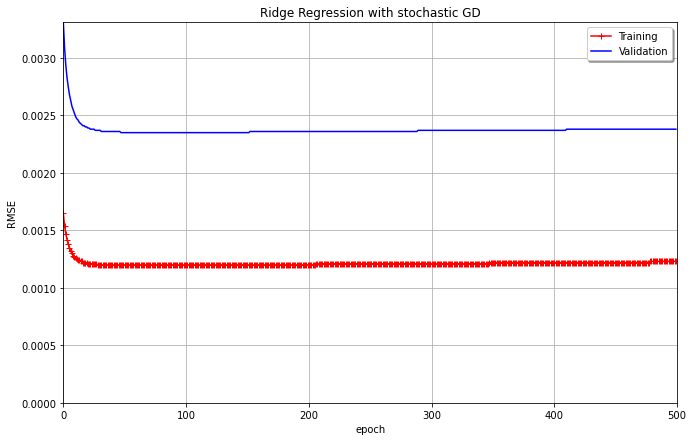

In [31]:
# Add a column of ones to X for the bias term
X_train_reshaped = np.c_[ X_train, np.ones(X_train.shape[0]) ]
X_valid_reshaped = np.c_[ X_valid, np.ones(X_valid.shape[0]) ]

# Make sure the shape of y is correct by
# reshaping it into a (n,1) vector, if needed.
if len(y_train.shape) != 1:
    y_train_reshaped = y_train.reshape(-1)

regressor = SGDRegressor(loss=loss, alpha=alpha, eta0=eta0, \
                         learning_rate=learning_rate, warm_start=True, \
                         random_state=0)

# Initialize cost lists (both trainings and validation),
# useful for plotting changes
train_costs = []
valid_costs = []

# In every epoch, use partial fit to stochastic regression
# over the whole training set
for i in range(epochs):
    regressor.partial_fit(X_train_reshaped, y_train_reshaped)
    w = regressor.coef_.reshape(-1,1)

    # Add costs to lists
    train_cost = round(cost(X_train_reshaped, y_train, w, alpha), 5)
    valid_cost = round(cost(X_valid_reshaped, y_valid, w, alpha), 5)
    train_costs.append(train_cost)
    valid_costs.append(valid_cost)

r2 = regressor.score(X_valid_reshaped, y_valid)
print(f"R-squared score: {round(r2, 5)}")

x_axis = list(range(epochs))
fig = plt.figure(figsize=(11, 7))
plt.plot(x_axis, train_costs, label="Training", color='r', marker='+')
plt.plot(x_axis, valid_costs, label="Validation", color='b')
plt.title(f"Ridge Regression with stochastic GD")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.xlim(0,epochs)
plt.ylim(0,max(max(train_costs),max(valid_costs)))
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

So, from the curves above we can see that our model starts converging to the minimum RMSE after less than 50 iterations.<br/>
We can also see that both the training and the validation curve go side-by-side, with minimum distance from each other.<br/>
Finally, the model neither overfits nor underfits the data, since both curvers have the same behavior.

However, the RMSE starts increasing in Stochastic Gradient Descent for Ridge Regression, which aligns with what happens with simple Gradient Descent for Ridge Regression.<br/>
This can become more obvious using higher values for $\alpha$.

## Neural Networks for Regression

Can we do better than the above using Neural Networks?

Neural networks offer the advantage of non-linearity, so we overcome the linear regression limitations.

Let's build a sequential fully-connected NN model and use Stochastic Gradient Descent as its optimizer. 

In [32]:
def build_model(X, y, activation=relu, units=[1204], dropout_rate=0.5, learning_rate=0.01):
    """
    Build a Neural Network model based on the data shape and the given parameters
    """
    # Model creation
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=X.shape[1:], name='input'))
    
    # Dense (intermediate) layers with dropout
    for i in range(len(units)):
        model.add(Dropout(rate=dropout_rate))
        model.add(Dense(units=units[i], activation=activation, name=f'layer_{i}'))
    
    # Output layers
    model.add(Dense(units=y.shape[1], name='output'))

    # Model compilation and description
    model.compile(optimizer=SGD(learning_rate=learning_rate), 
                  loss='mse', 
                  metrics=[RootMeanSquaredError()])
    model.summary()
    
    return model

These are the parameters that we are going to use for Neural Regression.

In [33]:
dropout_rate=0.0
learning_rate=0.01
patience=2
batch_size=256
epochs=100
units=[2048, 2048, 32]

In [35]:
model = build_model(X_train, y_train, relu, units, dropout_rate, 0.01)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 21)                0         
_________________________________________________________________
layer_0 (Dense)              (None, 2048)              45056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
layer_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
layer_2 (Dense)              (None, 32)                65568     
_________________________________________________________________
output (Dense)               (None, 1)                 3

Let's train the model.

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience)

model.fit(x=X_train, y=y_train, 
          validation_data=(X_valid, y_valid), 
          batch_size=batch_size, epochs=epochs, 
          callbacks=[early_stopping])

Train on 16346 samples, validate on 4087 samples
Epoch 1/100
16346/16346 [==============================] - 6s 376us/sample - loss: 0.0573 - root_mean_squared_error: 0.2393 - val_loss: 0.0427 - val_root_mean_squared_error: 0.2066
Epoch 2/100
16346/16346 [==============================] - 6s 337us/sample - loss: 0.0397 - root_mean_squared_error: 0.1992 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945
Epoch 3/100
16346/16346 [==============================] - 8s 484us/sample - loss: 0.0363 - root_mean_squared_error: 0.1905 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1876
Epoch 4/100
16346/16346 [==============================] - 8s 462us/sample - loss: 0.0340 - root_mean_squared_error: 0.1844 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1822
Epoch 5/100
16346/16346 [==============================] - 8s 490us/sample - loss: 0.0323 - root_mean_squared_error: 0.1796 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1779
Epoch 6/100
16346/16346 [=====================

Let's plot the losses.

<AxesSubplot:>

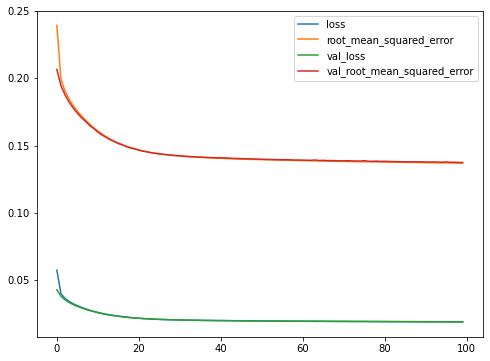

In [37]:
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(8,6))

Let's evaluate our model.

In [38]:
model.evaluate(X_valid, y_valid)

4087/4087 [==============================] - 3s 720us/sample - loss: 0.0189 - root_mean_squared_error: 0.1374


[0.01887822404261364, 0.13739806]

In [39]:
y_pred = model.predict(X_valid)
r2 = r2_score(y_valid, y_pred)
print(f"R-squared score: {round(r2, 5)}")

R-squared score: 0.66835


It's obvious from the $R^2$ score that we get a better fit with the fully-connected Neural Networks approach.<br/>
However, the errors and the losses are significantly higher than those of the Linear Regression.